# Preprocessing

In [ ]:
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import display, Markdown

%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Oct 22 2025

Python implementation: CPython
Python version       : 3.13.7
IPython version      : 9.6.0

matplotlib: 3.10.6
IPython   : 9.6.0
numpy     : 2.3.3
pandas    : 2.3.3

Watermark: 2.5.0



## Import Data

In [ ]:
raw = pd.read_csv("raw_data.csv")

## Name categorical variables

In [6]:
def set_categories(df: pd.DataFrame, col_name: str, categories: dict, ordered: bool = True) -> None:
    values = df[col_name].map(categories)
    cat_type = pd.CategoricalDtype(
        categories=list(categories.values()), ordered=ordered
        )
    df[col_name] = values.astype(cat_type)

sex_dict = {1: "Male", 2: "Female", 3: "Other"}
set_categories(raw, "sex", sex_dict)

gender_dict = {1.0: "Male", 2.0: "Female", 3.0: "Transgender", 4.0: "Other"}
set_categories(raw, "gender", gender_dict)

profession_dict = {
    1: "Doctor - neurology",
    2: "Doctor - psychiatry",
    3: "Doctor - rehabilitation",
    4: "Doctor - other",
    5: "Nurse",
    6: "Occupational therapist",
    7: "Physiotherapist",
    8: "Psychologist",
    9: "Scientist/research student",
    10: "Social worker",
    11: "Speech therapist",
    12: "Other clinician",
    13: "Other non-clinician",
}
set_categories(raw, "profession", profession_dict)

symptoms_dict = {1: "Yes", 0: "No"}
for symptom in ["motor", "sensory", "dissociation"]:
    set_categories(raw, symptom, symptoms_dict)

n_occurrences_dict = {
    1: "Only once",
    2: "2 or 3 times",
    3: "4 - 6 times",
    4: "7 - 10 times",
    5: "More than 10 times",
}
n_occurrence_columns = [
    "motor_n_occurrences",
    "sensory_n_occurrences",
    "dissociation_n_occurrences",
]
for col_name in n_occurrence_columns:
    set_categories(raw, col_name, n_occurrences_dict)

duration_dict = {
    1: "Less than a minute",
    2: "A few minutes",
    3: "More than a few minutes, but less than an hour",
    4: "More than an hour, but less than a day",
    5: "One day to one week",
    6: "One week to one month",
    7: "One month to three months",
    8: "Three months to a year",
    9: "More than a year",
}
duration_columns = ["motor_duration", "sensory_duration", "dissociation_duration"]
for col_name in duration_columns:
    set_categories(raw, col_name, duration_dict)

# Original values for impact:
# 1, Not at all | 2, Slightly (eg, felt uncomfortable at work or school, or while socialising) | 3, A little (made work, education, or socialising difficult) | 4, Quite a lot (required up to a few days off work or school, or limited ability to socialise in certain situations) | 5, A lot (required more than a few days off work or school, or significantly limited ability to socialise)

impact_dict = {
    1: "Not at all",
    2: "Slightly",
    3: "A little",
    4: "Quite a lot",
    5: "A lot",
}
impact_columns = ["motor_impact", "sensory_impact", "dissociation_impact"]
for col_name in impact_columns:
    set_categories(raw, col_name, impact_dict)

# Analysis

## Utility functions

In [7]:
def despine(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

## Describe sample

In [8]:
display(Markdown("## Response numbers"))
display(Markdown(f"Number of complete resonses: {raw['dissociation'].notna().sum()}"))

# Dissociation is the last question shown to all respondents, so if it has been
# answered, it is a better indicator of completion than the `survey_complete` column,
# which relies on the submit button being clicked.

display(
    Markdown(
        f"Respondents who have been diagnosed with FND (excluded from further analysis): {int(raw['fnd'].sum())}"
    )
)

raw = raw[raw["fnd"] == 0]

## Response numbers

Number of complete resonses: 95

Respondents who have been diagnosed with FND (excluded from further analysis): 0

In [9]:
display(Markdown("## Demographics"))

# Get sex breakdown
sexes = raw["sex"].value_counts(normalize=True) * 100
sexes = sexes.round(1)

display(Markdown(f"Sex distribution: {sexes.to_dict().items()}"))


# Get gender breakdown
genders = raw["gender"].value_counts(normalize=True) * 100
genders = genders.round(1)

display(Markdown(f"Gender distribution: {genders.to_dict().items()}"))


# Summarise age
age_mean = raw["age"].mean()
age_sd = raw["age"].std()
age_min = raw["age"].min()
age_max = raw["age"].max()

display(Markdown(f"Mean age: {age_mean:.1f} years (SD: {age_sd:.1f}, range: {age_min} - {age_max})"))


# Summarise profession
professions = raw["profession"].value_counts(normalize=True) * 100
professions = professions.round(1)

clinicians = professions[['Physiotherapist', 'Doctor - neurology', 'Psychologist', 'Doctor - other', 'Occupational therapist', 'Doctor - psychiatry', 'Other clinician', 'Doctor - rehabilitation', 'Nurse', 'Speech therapist']].sum()

display(Markdown(f"Profession distribution: {professions.to_dict().items()}"))
display(Markdown(f"Clinicians {clinicians:.1f}%  \n Scientists/research students {professions['Scientist/research student']:.1f}%  \n Other non-clinicians {professions['Other non-clinician']:.1f}%"))

## Demographics

Sex distribution: dict_items([('Female', 78.9), ('Male', 21.1), ('Other', 0.0)])

Gender distribution: dict_items([('Female', 75.8), ('Male', 21.1), ('Other', 3.2), ('Transgender', 0.0)])

Mean age: 40.5 years (SD: 10.5, range: 21.0 - 65.0)

Profession distribution: dict_items([('Physiotherapist', 29.5), ('Doctor - neurology', 18.9), ('Psychologist', 17.9), ('Doctor - other', 7.4), ('Occupational therapist', 7.4), ('Doctor - psychiatry', 5.3), ('Scientist/research student', 5.3), ('Other clinician', 3.2), ('Other non-clinician', 2.1), ('Nurse', 1.1), ('Doctor - rehabilitation', 1.1), ('Speech therapist', 1.1), ('Social worker', 0.0)])

Clinicians 92.9%  
 Scientists/research students 5.3%  
 Other non-clinicians 2.1%

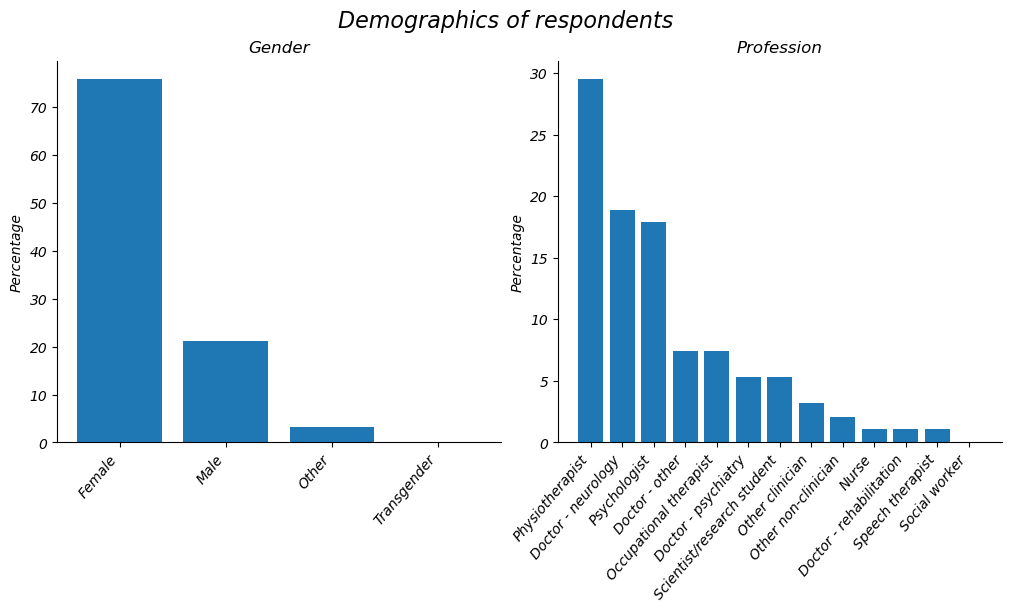

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), layout="constrained")

ax[0].bar(genders.index, genders)
ax[0].set_ylabel("Percentage")
ax[0].set_xlabel(None)
ax[0].set_title("Gender")
ax[0].set_xticks(range(len(genders)))
ax[0].set_xticklabels(genders.index, rotation = 50, ha="right")

ax[1].bar(professions.index, professions)
ax[1].set_ylabel("Percentage")
ax[1].set_xlabel("")
ax[1].set_title("Profession")
ax[1].set_xticks(range(len(professions)))
ax[1].set_xticklabels(professions.index, rotation = 50, ha="right")

fig.suptitle("Demographics of respondents", fontsize=16)

for a in ax:
    despine(a)

## Results

In [11]:
motor_percent = (
    raw.loc[raw["motor"].notna(), "motor"]
    .value_counts(normalize=True)
    .multiply(100)["Yes"]
)
display(Markdown(f"Proportion with motor symptoms: {motor_percent:.1f}%"))

sensory_percent = (
    raw.loc[raw["sensory"].notna(), "sensory"]
    .value_counts(normalize=True)
    .multiply(100)["Yes"]
)
display(Markdown(f"Proportion with sensory symptoms: {sensory_percent:.1f}%"))

dissociation_percent = (
    raw.loc[raw["dissociation"].notna(), "dissociation"]
    .value_counts(normalize=True)
    .multiply(100)["Yes"]
)
display(Markdown(f"Proportion with dissociation: {dissociation_percent:.1f}%"))


motor_or_sensory_percent = (
    raw.loc[raw["motor"].notna() & raw["sensory"].notna(), ["motor", "sensory"]]
    .apply(lambda row: (row["motor"] == "Yes") or (row["sensory"] == "Yes"), axis=1)
    .mean()
    * 100
)

any_symptom_prcent = (
    raw.loc[raw["motor"].notna() & raw["sensory"].notna() & raw["dissociation"].notna(), ["motor", "sensory", "dissociation"]]
    .apply(lambda row: (row["motor"] == "Yes") or (row["sensory"] == "Yes") or (row["dissociation"] == "Yes"), axis=1)
    .mean()
    * 100
)

display(
    Markdown(
        f"Proportion with either motor OR sensory symptoms: {motor_or_sensory_percent:.1f}%"
    )
)

motor_and_sensory_percent = (
    raw.loc[raw["motor"].notna() & raw["sensory"].notna(), ["motor", "sensory"]]
    .apply(lambda row: (row["motor"] == "Yes") and (row["sensory"] == "Yes"), axis=1)
    .mean()
    * 100
)
display(
    Markdown(
        f"Proportion with both motor AND sensory symptoms: {motor_and_sensory_percent:.1f}%"
    )
)
display(
    Markdown(
        f"Proportion with any symptom: {any_symptom_prcent:.1f}%"
    )
)

Proportion with motor symptoms: 20.2%

Proportion with sensory symptoms: 37.9%

Proportion with dissociation: 30.5%

Proportion with either motor OR sensory symptoms: 47.9%

Proportion with both motor AND sensory symptoms: 10.6%

Proportion with any symptom: 57.4%

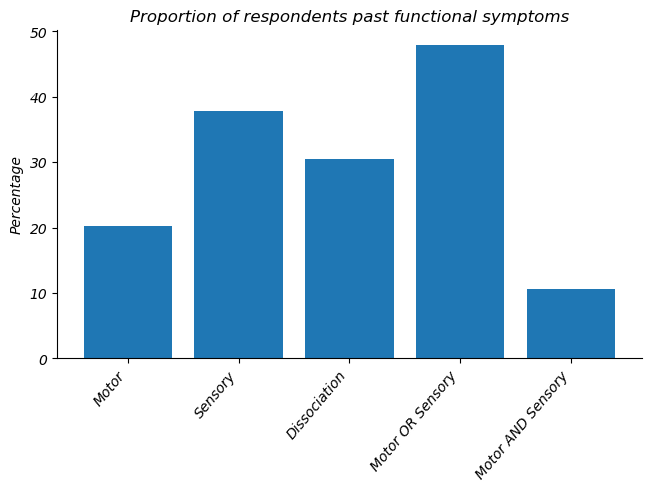

In [12]:
fig, ax = plt.subplots(layout="constrained")

symptoms = ["Motor", "Sensory", "Dissociation", "Motor OR Sensory", "Motor AND Sensory"]
frequencies = [
    motor_percent,
    sensory_percent,
    dissociation_percent,
    motor_or_sensory_percent,
    motor_and_sensory_percent,
]


ax.bar(symptoms, frequencies)

ax.set_ylabel("Percentage")

ax.set_title("Proportion of respondents past functional symptoms")
ax.set_xticks(range(len(symptoms)))
ax.set_xticklabels(symptoms, rotation=50, ha="right")


despine(ax)

In [13]:
"""
This cell fixes the categories of the categorical to include the full range of categories, whether used or not, and to order
"""
labels_duration = [
    "Less than a minute",
    "A few minutes",
    "More than a few minutes, but less than an hour",
    "More than an hour, but less than a day",
    "One day to one week",
    "One week to one month",
    "One month to three months",
    "Three months to a year",
    "More than a year",
]

labels_occurrences = [
    "Only once",
    "2 or 3 times",
    "4 – 6 times",
    "7 – 10 times",
    "More than 10 times"
]

labels_severity = [
    "Not at all",
    "Slightly",
    "A little",
    "Quite a lot",
    "A lot"
]

for symptom in ["motor", "sensory", "dissociation"]:
    for colname in ["duration", "n_occurrences", "impact"]:
        col_to_change = f"{symptom}_{colname}"
        
        if colname == "duration":
            labels = labels_duration
        elif colname == "n_occurrences":
            labels = labels_occurrences
        elif colname == "impact":
            labels = labels_severity

        raw[col_to_change] = raw[col_to_change].cat.set_categories(labels, ordered=True)


In [14]:
def plot_categorical(series, colour, ax, barthickness=0.1):
    # Get value counts and arrange in the order of the ordered categories
    d = series.value_counts(normalize=True, sort=False)

    # Add bar chart
    ax.barh(d.index, d, color=colour, height=0.6)

    # Set numerical y-axis with one category per number
    ax.set_yticks(range(len(d)))
    ax.set_yticklabels(d.index)

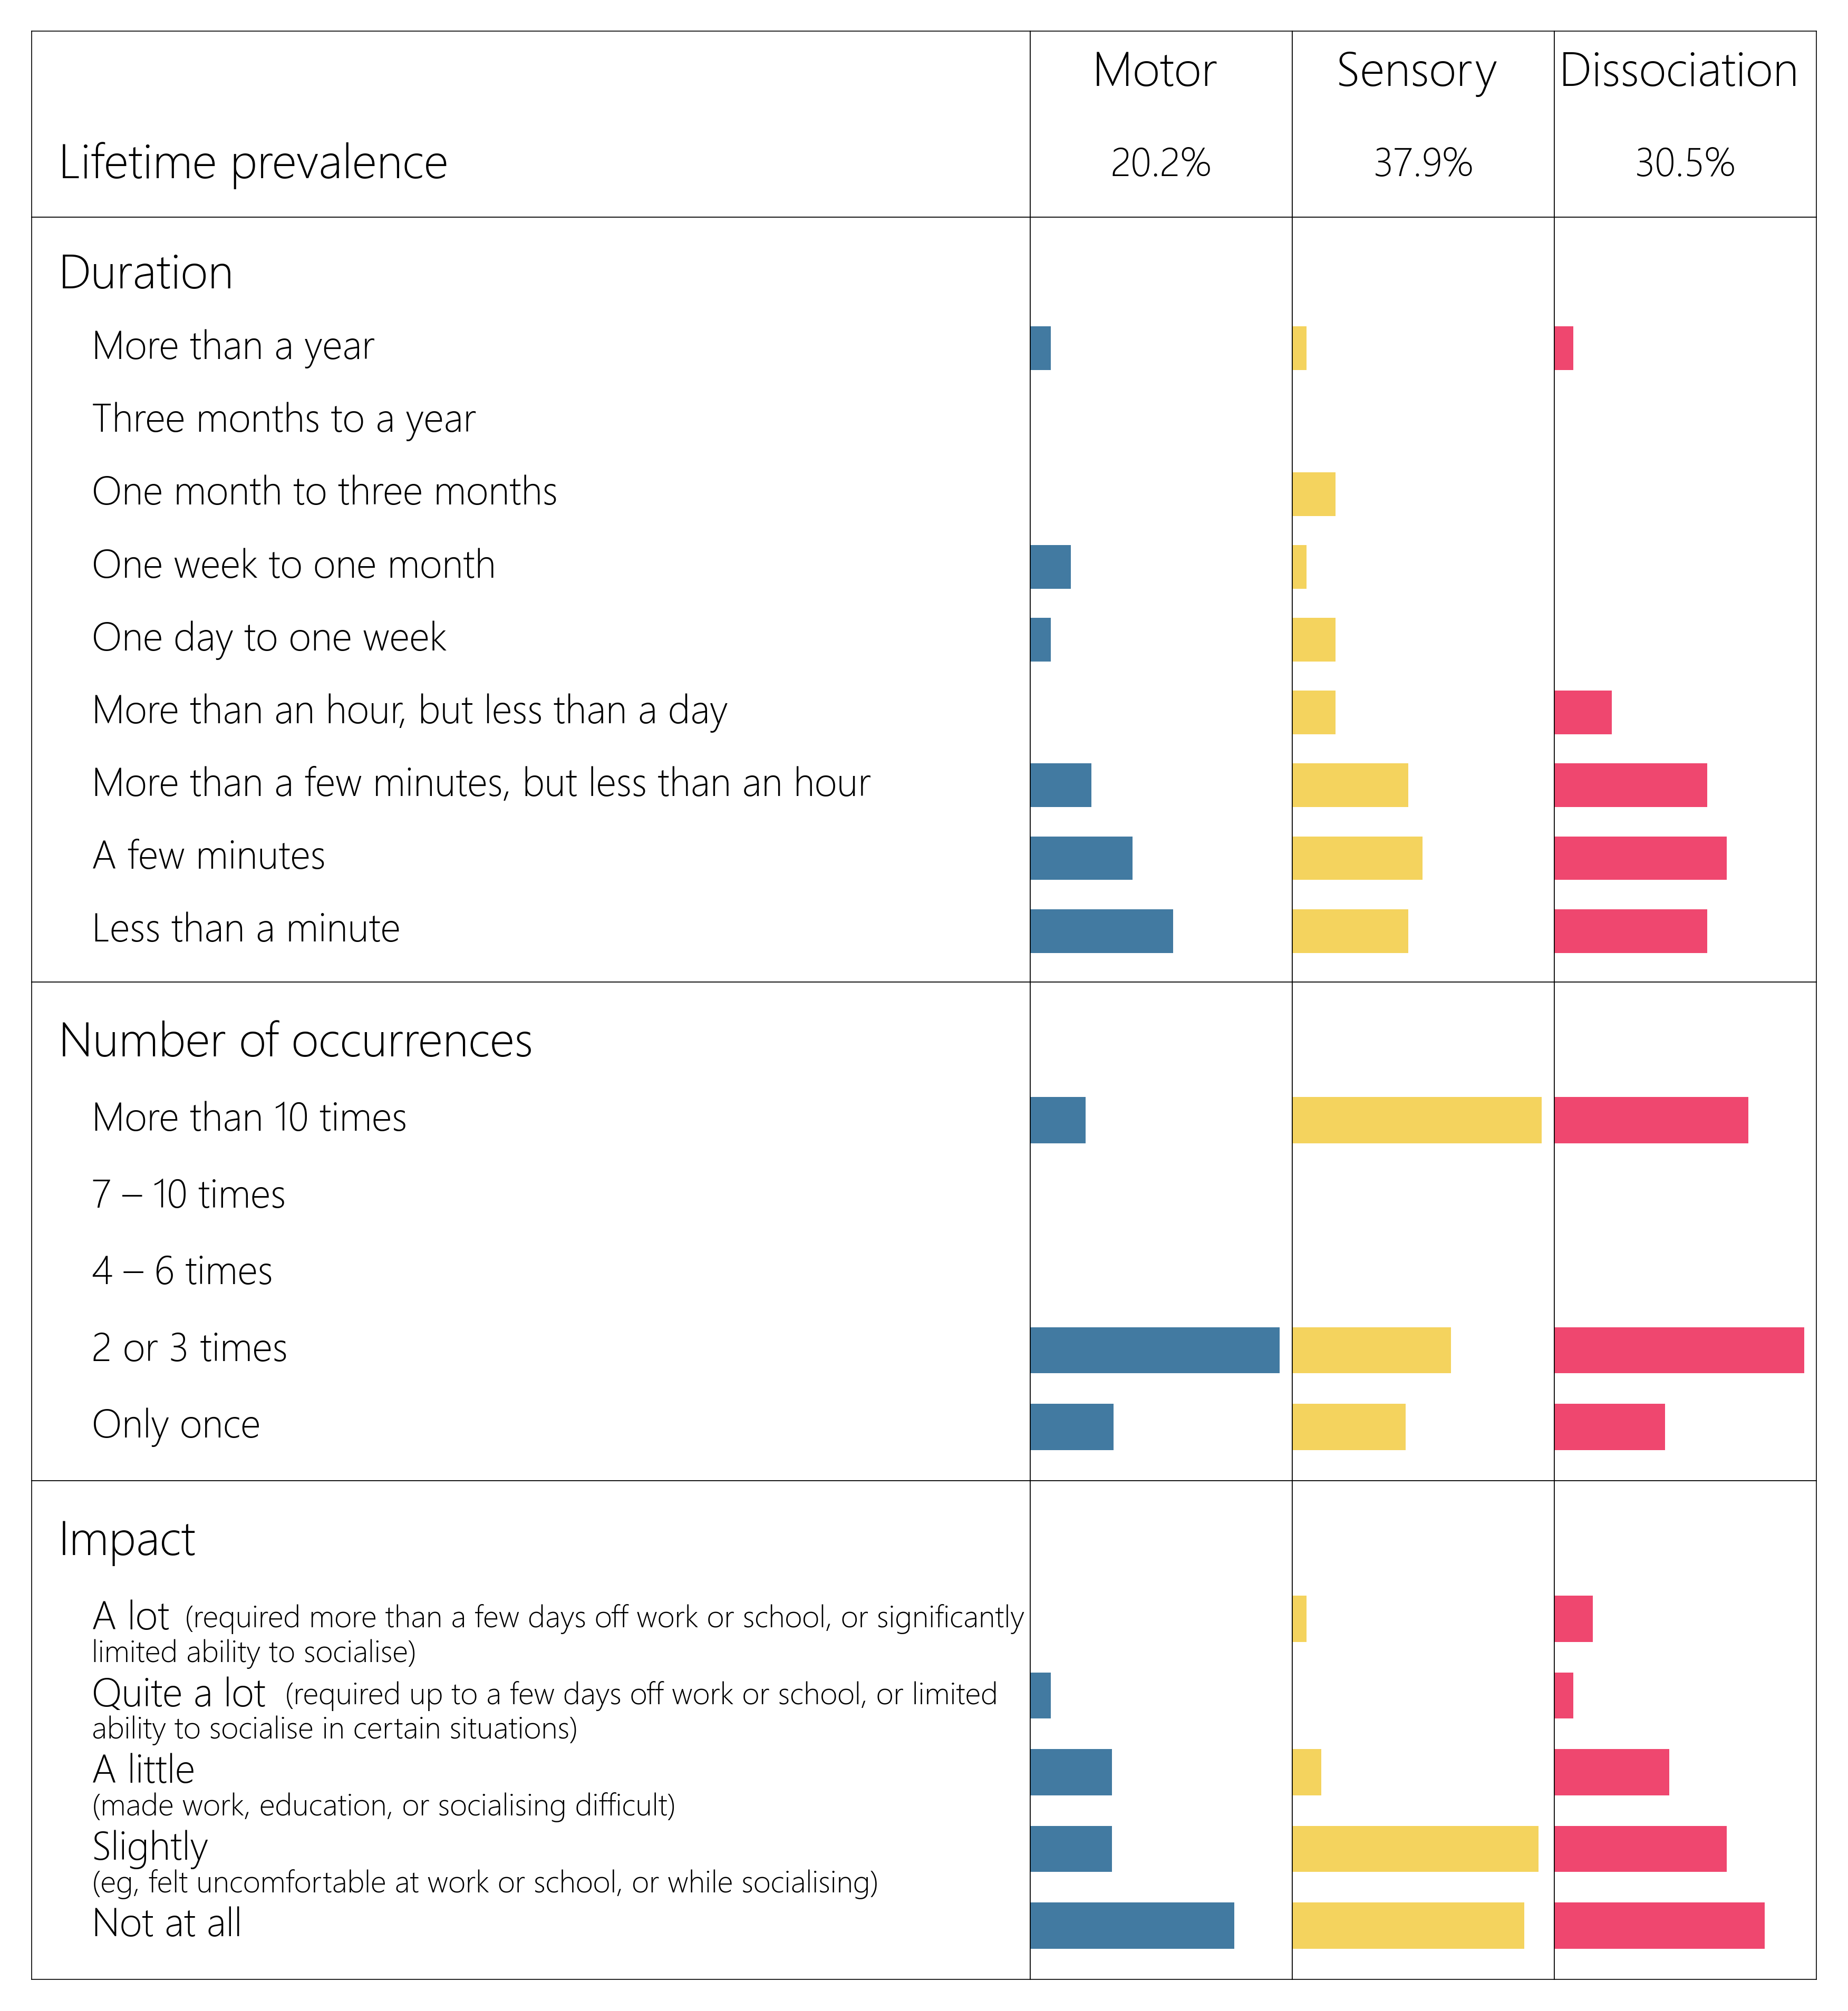

In [15]:
"""
This cell generates the table of graphs and inserts the text.
"""

margin=0.4
indent=0.5
FONT= 'Segoe UI'#"Gill Sans MT"

def create_graph_table(n_rows,plots_per_row, width_ratios=(4, 1), n_categories=(1, 9, 5, 5), top_padding = 0.8, bottom_padding = 0.7, add_height = (1, 1, 1, 1), font=FONT):
    mpl.rcParams['axes.linewidth'] = 0.2
    n_text_rows_including_title = np.array(n_categories) * np.array(add_height) + 1
    height_ratios = n_text_rows_including_title + top_padding + bottom_padding
    fig, axs = plt.subplots(n_rows, plots_per_row + 1, sharex="col", sharey="row", 
    width_ratios=width_ratios, height_ratios=height_ratios, figsize=(7.28, 8), dpi=600)
    
    # Remove vertical space between Axes
    fig.subplots_adjust(hspace=0, wspace=0)

    for i in range(0, 4):
        for j in range(0, 4):
            # Remove ticks and labels from the left hand cells
            axs[i, j].tick_params(
            axis='both',
            which='both',
            bottom=False,
            top=False,
            left=False,
            right=False,
            labelbottom=False,
            labelleft=False,
            )
        axs[i, 0].set_ylim(-0.7, n_categories[i] + 0.8)
        axs[i, 0].set_xlim(0, 15)

    return fig, axs

fig, axs = create_graph_table(4, 3, (4, 1.05, 1.05, 1.05), add_height = (0.3, 1, 1, 1))

def add_text(row, title, labels, margin=0.4, indent=0.5, font=FONT):
    for i, label in enumerate(labels):
        axs[row, 0].text(margin + indent, i, label, verticalalignment="center", fontsize = 9, font=font, fontweight="light")

    axs[row, 0].text(margin, i+1, title, verticalalignment="center", fontsize = 11, font=font, fontweight="light")

axs[0, 0].text(margin, 0, "Lifetime prevalence", verticalalignment="center", fontsize = 11, font=FONT, fontweight="light")
add_text(1, "Duration", labels_duration)
add_text(2, "Number of occurrences", labels_occurrences)
add_text(3, "Impact", labels_severity)


def add_explanations(row, explanations, margin=0.4, indent=0.5, font=FONT):
    for i, label in enumerate(explanations):
        axs[row, 0].text(margin + indent, i - 0.45, label, verticalalignment="center", fontsize = 7, font=font, fontweight="light")

explanations_severity = [
    "",
    "(eg, felt uncomfortable at work or school, or while socialising)",
    "(made work, education, or socialising difficult)",
    "ability to socialise in certain situations)", # Start is cut off to be printed separately below
    "limited ability to socialise)" # Start is cut off to be printed separately below
]

add_explanations(3, explanations_severity)

axs[3, 0].text(margin + indent + 1.4, 4, "(required more than a few days off work or school, or significantly", verticalalignment="center", fontsize = 7, font=FONT, fontweight="light")

axs[3, 0].text(margin + indent + 2.9, 3, "(required up to a few days off work or school, or limited", verticalalignment="center", fontsize = 7, font=FONT, fontweight="light")

for i, (symptom, colour) in enumerate(zip(["motor", "sensory", "dissociation"], ["#427aa1", "#f4d35e", "#ef476f"])):
    for j, colname in zip([1, 2, 3], ["duration", "n_occurrences", "impact"]):
        plot_categorical(raw[f"{symptom}_{colname}"], colour, axs[j, i + 1])
    axs[0, i + 1].text(0.5, 0.9, f"{symptom.capitalize()} ", fontsize=11, fontweight="light", font=FONT, ha = "center", va = "top", transform=axs[0, i + 1].transAxes)

def add_proportion(col, proportion):
    axs[0, col].text(axs[0, col].get_xlim()[1] / 2, 0, f"{proportion:.1f}%", verticalalignment="center", horizontalalignment='center', fontsize = 9, font=FONT, fontweight="light")

for i, proportion in enumerate([motor_percent, sensory_percent, dissociation_percent]):
    add_proportion(i + 1, proportion)

fig.savefig("symptom_characteristics.png", dpi=600, bbox_inches="tight")

Life impact for people who reported symptoms greater than a year in duration.

In [16]:
raw[(raw["motor_duration"] == "More than a year") | (raw["sensory_duration"] == "More than a year") | (raw["dissociation_duration"] == "More than a year")][["motor_duration", "sensory_duration", "dissociation_duration", "motor_impact", "sensory_impact", "dissociation_impact"]]

,motor_duration,sensory_duration,dissociation_duration,motor_impact,sensory_impact,dissociation_impact
13,One week to one month,More than a year,A few minutes,Not at all,Slightly,Not at all
56,NaN,"More than a few minutes, but less than an hour",More than a year,NaN,Slightly,A lot
74,More than a year,"More than a few minutes, but less than an hour",NaN,A little,Not at all,NaN


In [17]:
def get_quantile_category(df, quantile, category, characteristic):
    col_name = f"{category}_{characteristic}"
    counts = df.loc[df[col_name].notna(), col_name].value_counts(sort=False)
    total = counts.sum()
    count_to_here = []
    for count in counts.items():
        # print(count)
        count_to_here.append(count[1])
        if np.array(count_to_here).sum() >= total * quantile:
            return count[0]


categories = ["motor", "sensory", "dissociation"]
characteristics = ["duration", "n_occurrences", "impact"]

for symptom in categories:
    display(Markdown(f"## {symptom.capitalize()}"))
    for characteristic in characteristics:
        display(Markdown(f"Median {characteristic.capitalize().replace('_', ' ')}: {get_quantile_category(raw, 0.5, symptom, characteristic)} (quartiles: {get_quantile_category(raw, 0.25, symptom, characteristic)}; {get_quantile_category(raw, 0.75, symptom, characteristic)})"))

## Motor

Median Duration: A few minutes (quartiles: Less than a minute; More than a few minutes, but less than an hour)

Median N occurrences: 2 or 3 times (quartiles: 2 or 3 times; 2 or 3 times)

Median Impact: Not at all (quartiles: Not at all; A little)

## Sensory

Median Duration: More than a few minutes, but less than an hour (quartiles: A few minutes; More than an hour, but less than a day)

Median N occurrences: 2 or 3 times (quartiles: 2 or 3 times; More than 10 times)

Median Impact: Slightly (quartiles: Not at all; Slightly)

## Dissociation

Median Duration: A few minutes (quartiles: Less than a minute; More than a few minutes, but less than an hour)

Median N occurrences: 2 or 3 times (quartiles: 2 or 3 times; More than 10 times)

Median Impact: Slightly (quartiles: Not at all; A little)